# A/D Asynchronous Delta Modulator

Following the ideas in [Corradi et al. 2015](../papers/07305828.pdf), we are going to extract spike trains from radio signals using an algorithm that simulates an A/D Asynchronous Delta Modulator. The basic principle is summarized in the following schematic

![A/D Asynchronous Delta Modulator](images/delta-modulator.png)

Thus, an input signal $V_{in}$ drives a transconductance $G_{out}$, which is compared against two thresholds $V_{thrup}$ and $V_{thrdn}$. If $G_{out}$ crosses either $V_{thrup}$ or $V_{thrdn}$, the pulse UP or DN is produced and $G_{out}$ is reset to a reference voltage $V_{ref} = V_{dd}/2$. The threshold values in [Corradi et al. 2015](../papers/07305828.pdf) are set to $V_{thrup} = V_{dd}/2 + V_{dd}/10$ and $V_{thrdn} = V_{dd}/2 - V_{dd}/10$

## Implementation

In the following implementation of the A/D Delta Modulator, we skip the operational transconductance amplifier and directly compare the signal $V_{in}$ to the thresholds $V_{thrup}$ and $V_{thrdn}$. The radioML dataset consists of $128\mu s$ long signals sampled at $1M\text{sample}/s$. Thus we need to interpolate them before we can feed them to the Delta Modulator and obtain UP and DN spike trains. We will use linear functions as in [Corradi et al. 2015](../papers/07305828.pdf) to interpolate the signals, but cubic splines could also be used.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import pandas as pd
import pickle
from sklearn.preprocessing import Normalizer
from scipy.interpolate import interp1d

Implement the DeltaModulator component

In [3]:
class AsynchronousDeltaModulator:

    def __init__(self, thrup, thrdn, resampling_factor):
        self.thrup = thrup
        self.thrdn = thrdn
        self.resampling_factor = resampling_factor
        self.time_length = None
        self.time_resampled = None
        self.vin = None
        self.rec = None
        self.up = None
        self.dn = None
        self.time_step = None

    def interpolate(self, time, vin):
        self.time_resampled, self.time_step = np.linspace(np.min(time), np.max(time), num=len(vin)*self.resampling_factor, endpoint=True, retstep=True)
        self.vin = interp1d(time, vin, kind='linear')(self.time_resampled)
        self.time_length = len(self.vin)
 
    def encode(self):
        self.up = np.zeros(self.time_length, dtype=bool)
        self.dn = np.zeros(self.time_length, dtype=bool)
        actual_dc = self.vin[0]
        for i in range(self.time_length):
            if (actual_dc + self.thrup) < self.vin[i]:
                self.up[i] = True
                actual_dc = self.vin[i]
            elif (actual_dc - self.thrdn) > self.vin[i]:
                self.dn[i] = True
                actual_dc = self.vin[i]

    def decode(self):
        actual_dc = self.vin[0]
        self.rec = np.zeros_like(self.vin)
        for i in range(self.time_length):
            if self.up[i]:
                actual_dc = actual_dc + self.thrup
            if self.dn[i]:
                actual_dc = actual_dc - self.thrdn
            self.rec[i] = actual_dc

Import the radioML dataset

In [8]:
with open("../data/radioML/RML2016.10a_dict.pkl", "rb") as f:
    dataset = pickle.load(f, encoding="latin1")

Let's run the DeltaModulator on a subset of samples from each modulation class at a fixed SNR level.

In [5]:
labels = ['I.up', 'I.dn', 'Q.up', 'Q.dn']
time = np.arange(128)
resampling_factor = 200
thrup = 0.01
thrdn = 0.01
adm_I = AsynchronousDeltaModulator(thrup, thrdn, resampling_factor)
adm_Q = AsynchronousDeltaModulator(thrup, thrdn, resampling_factor)

In [6]:
def plot_examples(examples, mod, snr):
    counts = np.zeros((len(examples), len(labels)))
    fig = plt.figure(figsize=(18, 24))
    grid = grs.GridSpec(len(examples), 1, wspace=0.3, hspace=0.3)
    for (i, e) in enumerate(examples):
        adm_I.interpolate(time, e[0, :])
        adm_Q.interpolate(time, e[1, :])
        adm_I.encode()
        adm_Q.encode()
        inner_grid = grs.GridSpecFromSubplotSpec(3, 1,
                subplot_spec=grid[i], wspace=0.0, hspace=0.0)
        ax1 = plt.Subplot(fig, inner_grid[0])
        ax1.set_title('{} @ {}dB - sample #{}'.format(mod, snr, i+1))
        ax1.plot(adm_I.time_resampled, adm_I.vin, color='#2ecc71', label='I')
        ax1.plot(adm_Q.time_resampled, adm_Q.vin, color='#e67e22', label='Q')
        ax1.legend(loc='upper right')
        ax2 = plt.Subplot(fig, inner_grid[1])
        ax2.set_yticks([])
        ax2.set_ylabel('I')
        ax2.vlines(adm_I.time_resampled[adm_I.up], ymin=0.0, ymax=1.0, colors='#3498db', linewidth=1)
        ax2.vlines(adm_I.time_resampled[adm_I.dn], ymin=-1.0, ymax=0.0, colors='#e74c3c', linewidth=1)
        ax3 = plt.Subplot(fig, inner_grid[2])
        ax3.set_yticks([])
        ax3.set_ylabel('Q')
        ax3.set_xlabel('Time [$\mu$s]')
        ax3.vlines(adm_Q.time_resampled[adm_Q.up], ymin=0.0, ymax=1.0, colors='#3498db', linewidth=1)
        ax3.vlines(adm_Q.time_resampled[adm_Q.dn], ymin=-1.0, ymax=0.0, colors='#e74c3c', linewidth=1)
        fig.add_subplot(ax1)
        fig.add_subplot(ax2)
        fig.add_subplot(ax3)
        counts[i, :] = [
            np.count_nonzero(adm_I.up),
            np.count_nonzero(adm_I.dn),
            np.count_nonzero(adm_Q.up),
            np.count_nonzero(adm_Q.dn)
        ]
    return counts

## PSK
In this modulation group digital data is modulated into the I and Q components of a radio signal by changing the relative phase between the two.

### BPSK
Binary Phase Shift Keying has two possible phase shifts: 0 and 180°.

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 97.8
	 - I.dn: 98.6
	 - Q.up: 85.2
	 - Q.dn: 87.0


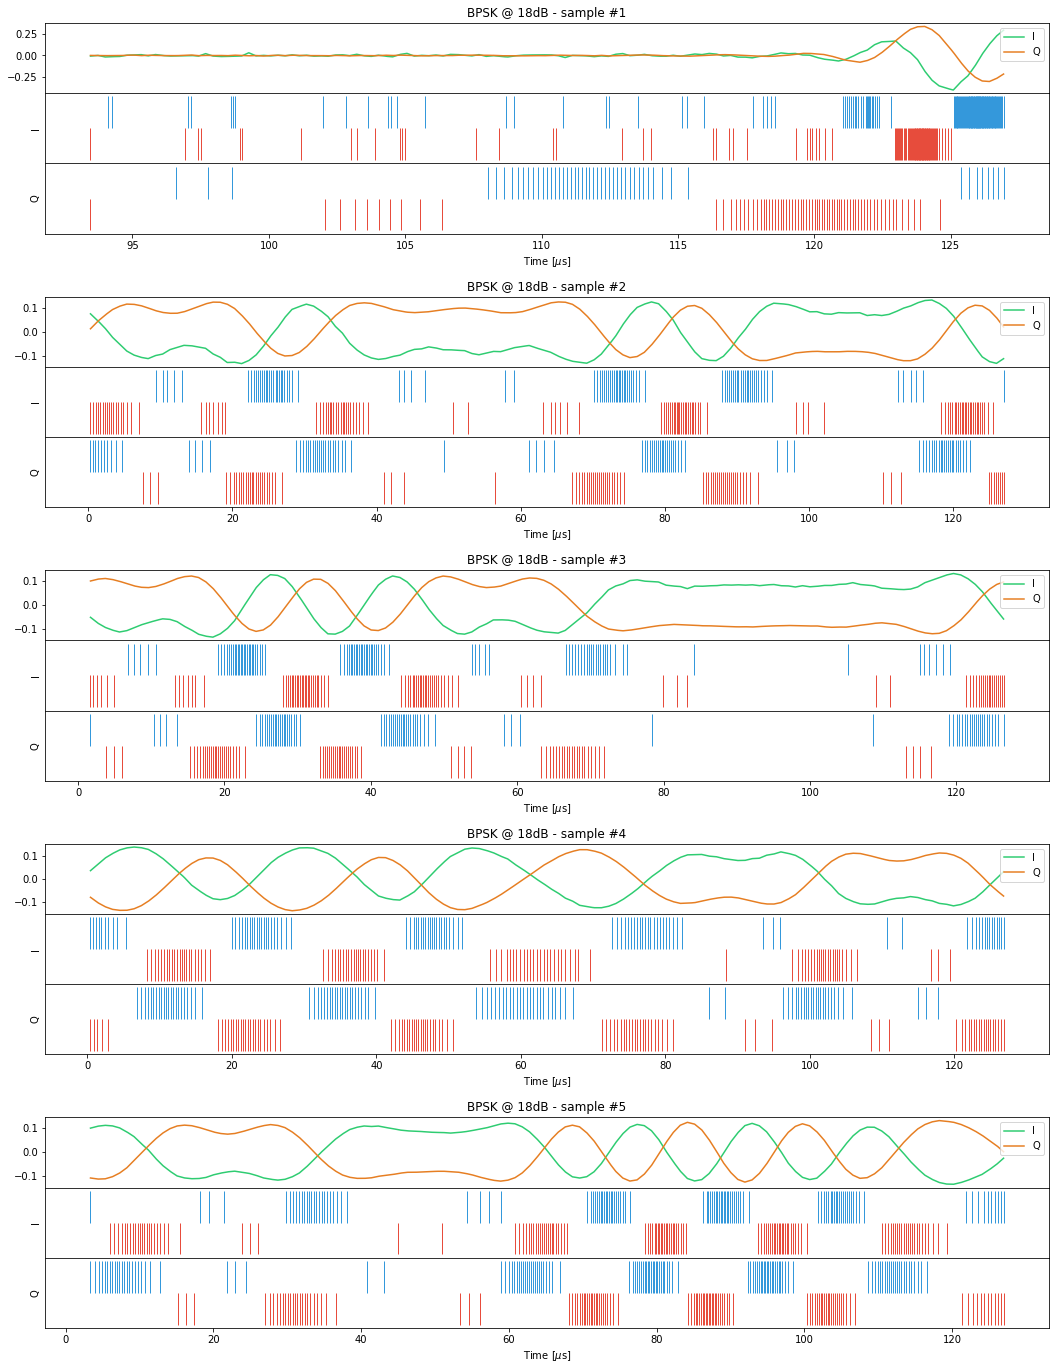

In [9]:
examples = dataset[('BPSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, 'BPSK', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

The BPSK modulation is characterized by anti-correlation between the same channels and by correlation between opposite channels in the I and Q components. This means that for example when the I.up channel is spiking the Q.up channel is silent, while there are almost synchronous spikes in the Q.dn channel.

### QPSK
Quadrature Phase Shift Keying has 4 possible phase shifts: 0, 90, 180 and 270°.

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 89.6
	 - I.dn: 91.4
	 - Q.up: 97.2
	 - Q.dn: 102.0


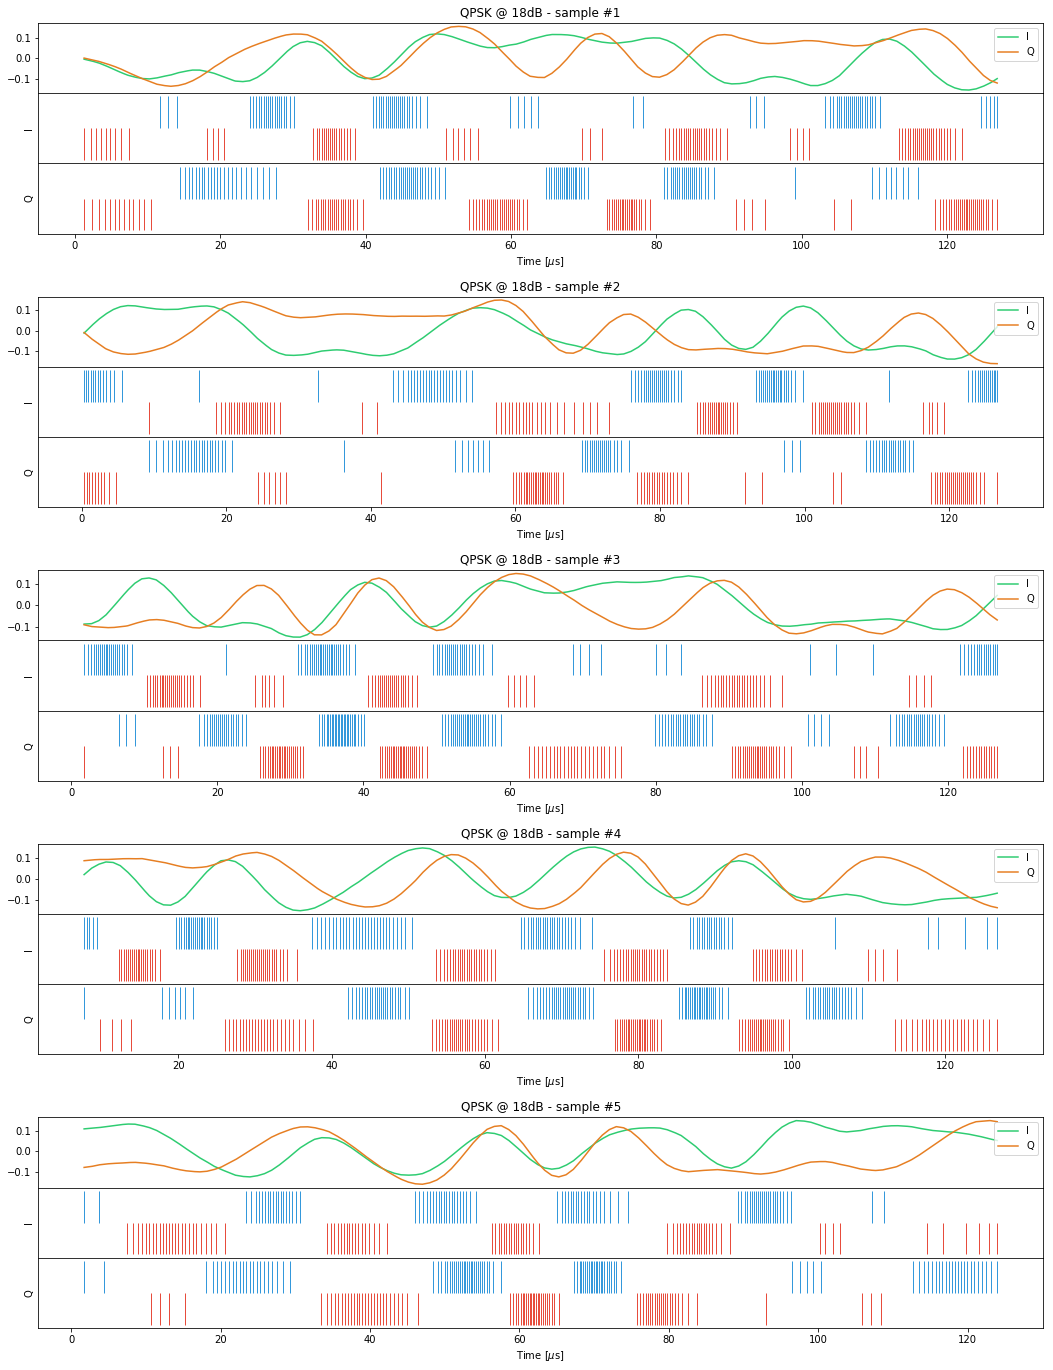

In [11]:
examples = dataset[('QPSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, 'QPSK', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

In QPSK a phase shift of 0° means there is almost perfect correlation between the up and dn channels of the I and Q components, whereas for a phase shift of 180° (as we saw above in the BPSK examples) the spikes from a same channel are anti-correlated and the spikes from opposite channels are correlated. For 90° and 270° there should be a 50% overlap in the spikes from the same channels across the I and Q components.

### 8PSK
8-Phase Shift Keying has 8 possible phase shifts: 0, 45, 90, 135, 180, 225, 270 and 315°.

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 100.4
	 - I.dn: 96.6
	 - Q.up: 96.8
	 - Q.dn: 94.0


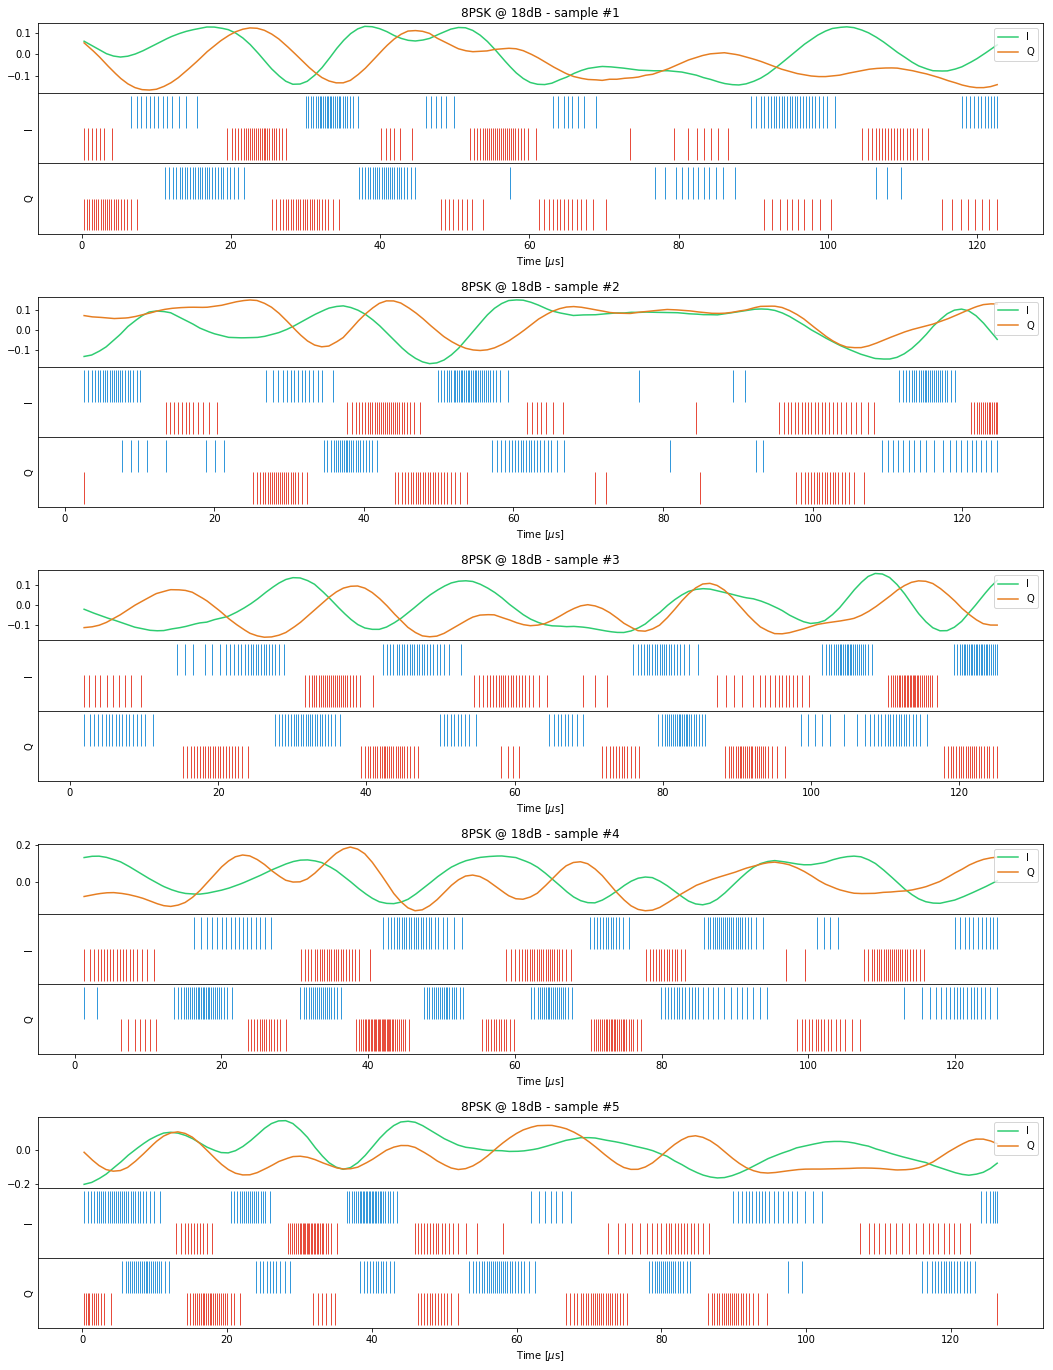

In [12]:
examples = dataset[('8PSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, '8PSK', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

For 8PSK the possible phases of the carries wave become 8 so the spikes in addition to the overlap possibilities of QPSK, can also have an overlap of about 25% and 75%.

### Synthetic example
Let's construct synthetic signals that have a constant phase shift of 0, 45, 90, 135, 180, 225, 270 and 315° to illustrate the possible correlation patterns between the channels for the I and Q componets.

In [13]:
T = np.linspace(0, 8*np.pi, num=256)
phases = [(np.pi/4)*i for i in range(8)]
phases_deg = [45*i for i in range(8)]
examples = []
for p in phases:
    I = np.sin(T/4*np.pi)
    Q = np.sin(T/4*np.pi+p)
    examples.append([I, Q])
examples = np.array(examples)

In [14]:
syn_adm_I = AsynchronousDeltaModulator(0.1, 0.1, 100)
syn_adm_Q = AsynchronousDeltaModulator(0.1, 0.1, 100)

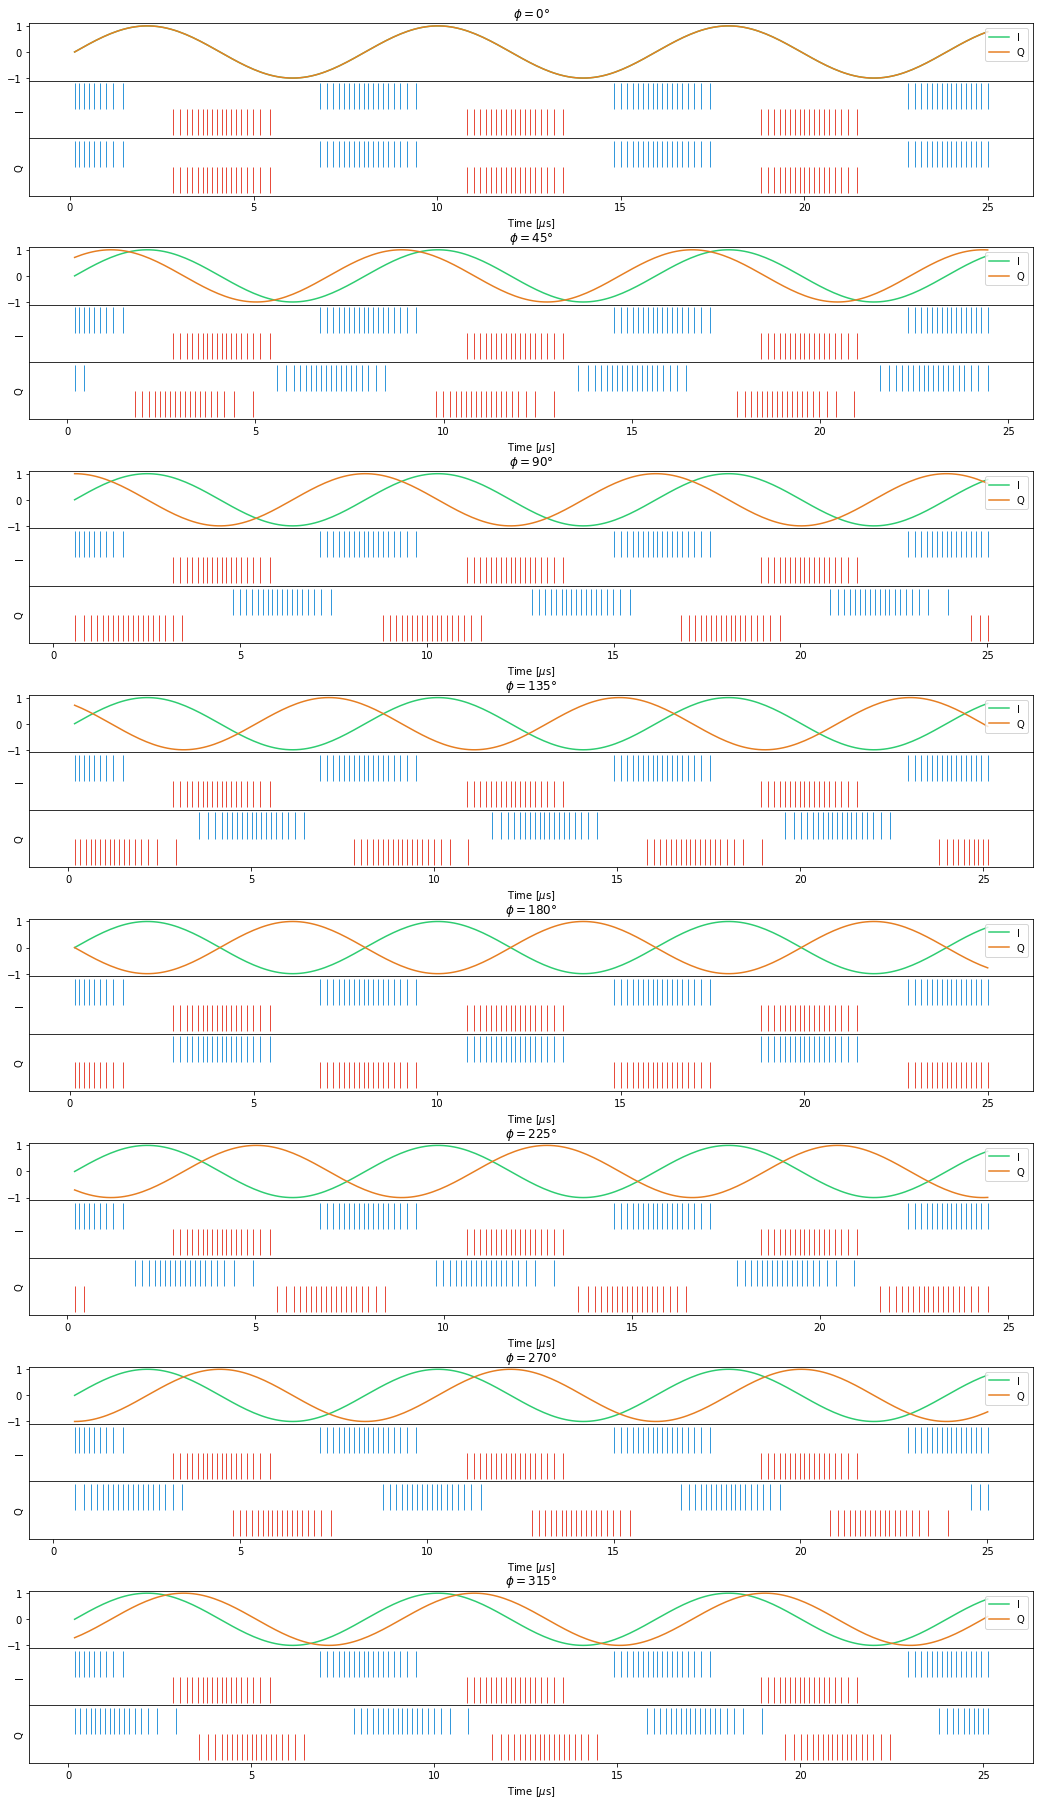

In [15]:
fig = plt.figure(figsize=(18, 32))
grid = grs.GridSpec(len(examples), 1, wspace=0.3, hspace=0.3)
for (i, e) in enumerate(examples):
    inner_grid = grs.GridSpecFromSubplotSpec(3, 1,
            subplot_spec=grid[i], wspace=0.0, hspace=0.0)
    ax1 = plt.Subplot(fig, inner_grid[0])
    ax1.plot(T, e[0,:], color='#2ecc71', label='I')
    ax1.plot(T, e[1,:], color='#e67e22', label='Q')
    ax1.legend(loc='upper right')
    ax1.set_title('$\phi={}°$'.format(phases_deg[i]))
    syn_adm_I.interpolate(T, e[0, :])
    syn_adm_Q.interpolate(T, e[1, :])
    syn_adm_I.encode()
    syn_adm_Q.encode()
    ax2 = plt.Subplot(fig, inner_grid[1])
    ax2.set_yticks([])
    ax2.set_ylabel('I')
    ax2.vlines(syn_adm_I.time_resampled[syn_adm_I.up], ymin=0.0, ymax=1.0, colors='#3498db', linewidth=1)
    ax2.vlines(syn_adm_I.time_resampled[syn_adm_I.dn], ymin=-1.0, ymax=0.0, colors='#e74c3c', linewidth=1)
    ax3 = plt.Subplot(fig, inner_grid[2])
    ax3.set_yticks([])
    ax3.set_ylabel('Q')
    ax3.set_xlabel('Time [$\mu$s]')
    ax3.vlines(syn_adm_Q.time_resampled[syn_adm_Q.up], ymin=0.0, ymax=1.0, colors='#3498db', linewidth=1)
    ax3.vlines(syn_adm_Q.time_resampled[syn_adm_Q.dn], ymin=-1.0, ymax=0.0, colors='#e74c3c', linewidth=1)
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
    fig.add_subplot(ax3)

## FSK
In this modulation group digital data is modulated into the I and Q components of a radio signal by changing frequency of the carrier signal in discrete steps.

### CPFSK

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 87.4
	 - I.dn: 93.4
	 - Q.up: 90.2
	 - Q.dn: 85.8


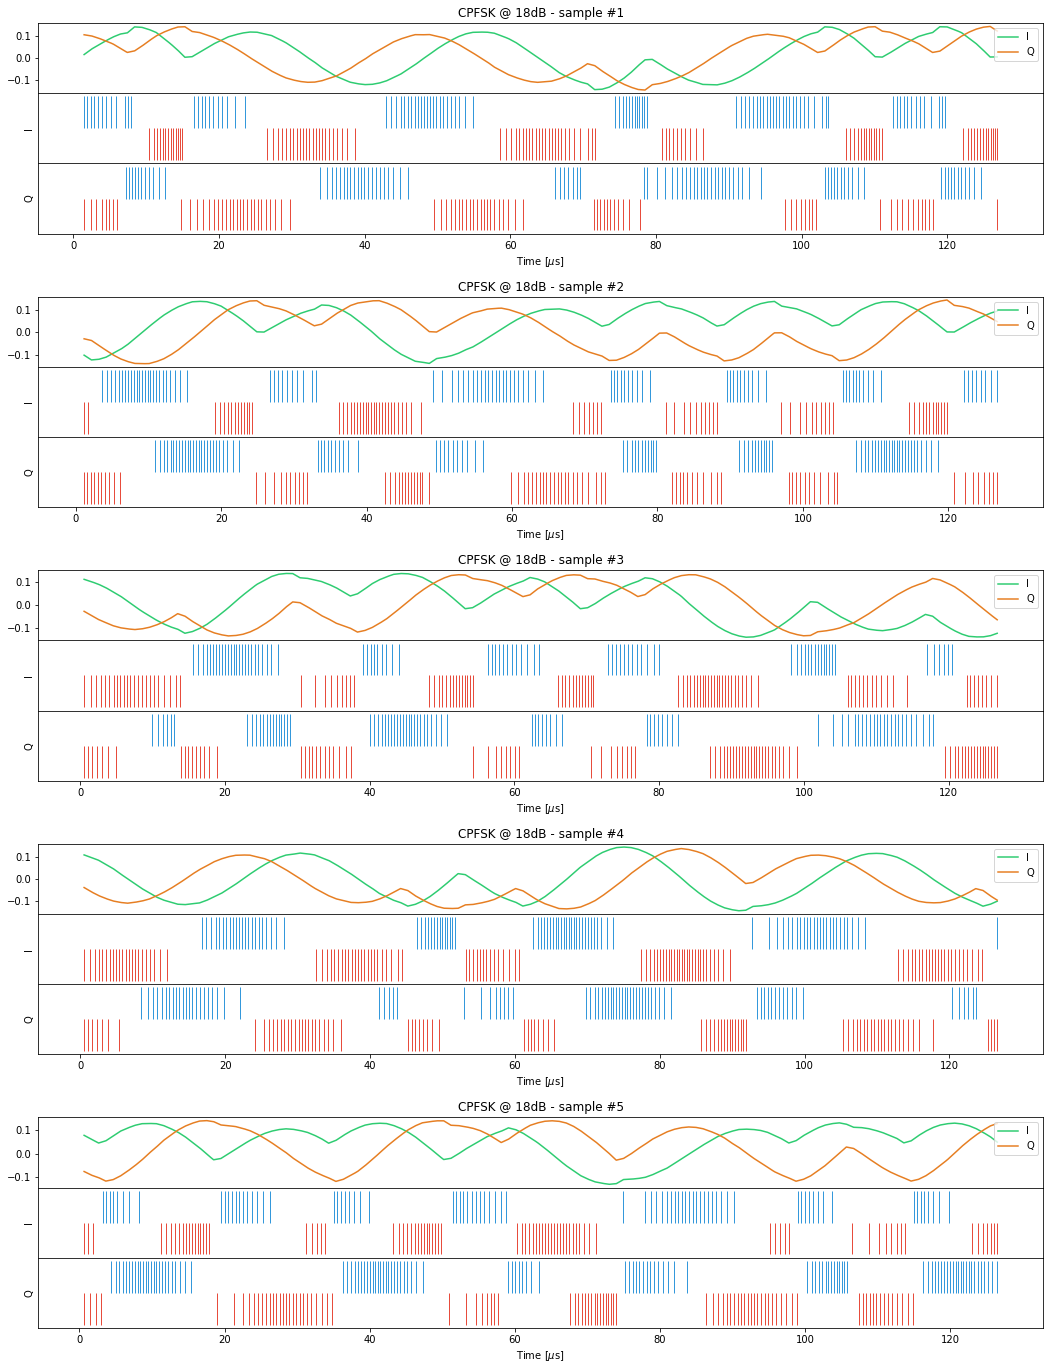

In [16]:
examples = dataset[('CPFSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, 'CPFSK', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

### GFSK

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 29.2
	 - I.dn: 31.6
	 - Q.up: 31.4
	 - Q.dn: 35.0


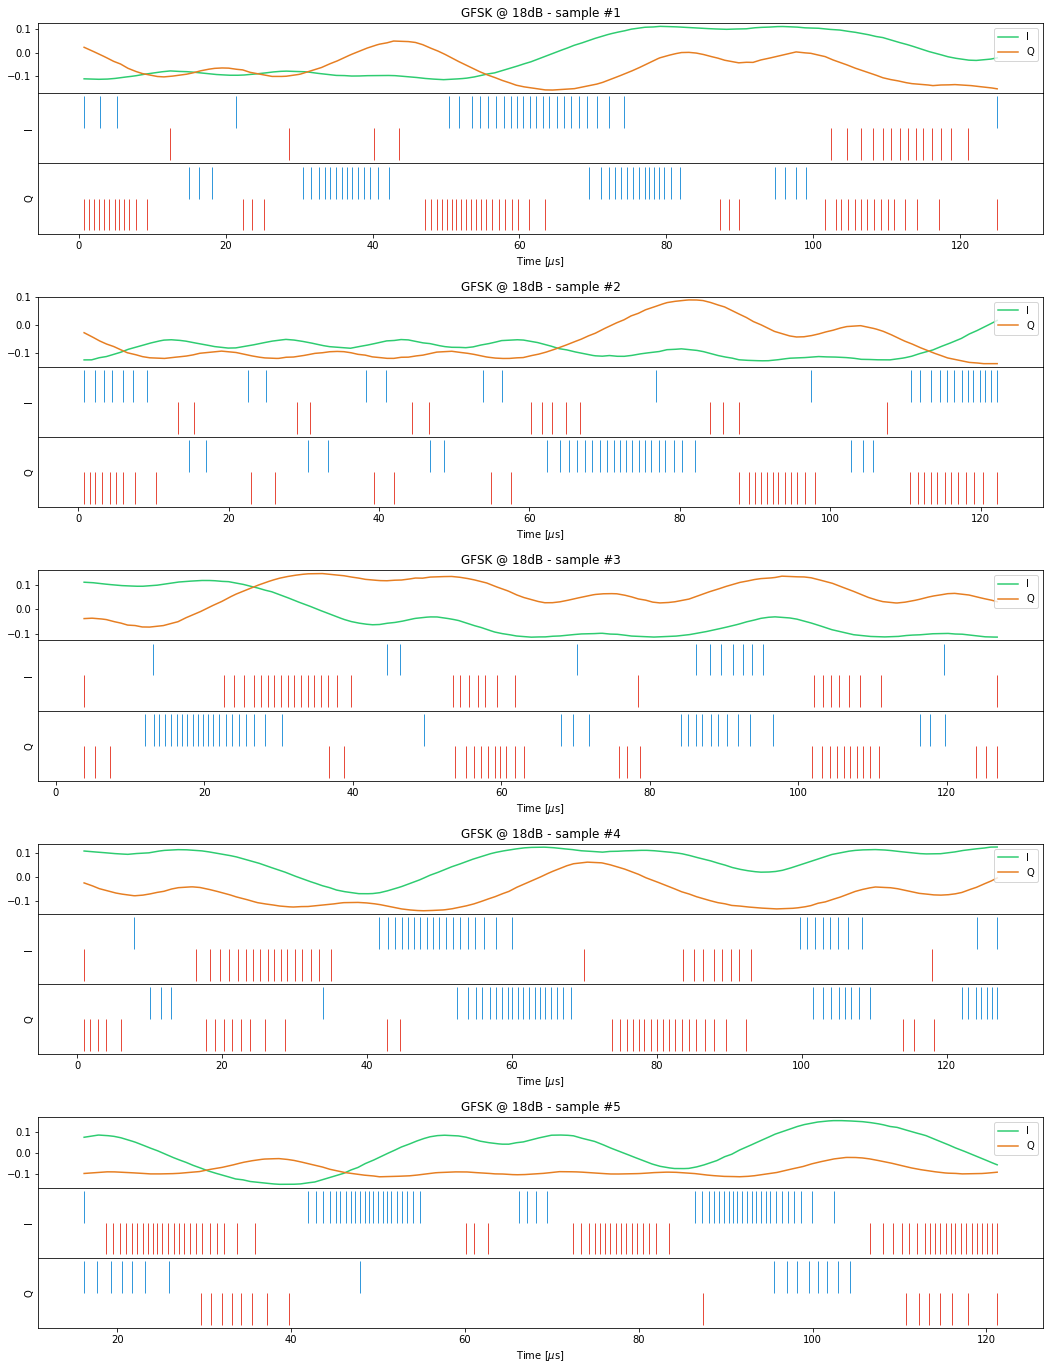

In [17]:
examples = dataset[('GFSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, 'GFSK', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

## ASK
Amplitude Shift Keying works by changing the amplitude of a carrier wave in discrete steps.

### QAM16
In the case of QAM, the carrier wave is the sum of two sinusoidal waves of the same frequency, 90° out of phase with each other (in quadrature). These are often called the "I" or in-phase component, and the "Q" or quadrature component. Each component is amplitude modulated, which is equivalent to modulating the phase of a carrier wave.

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 95.4
	 - I.dn: 87.0
	 - Q.up: 100.8
	 - Q.dn: 91.8


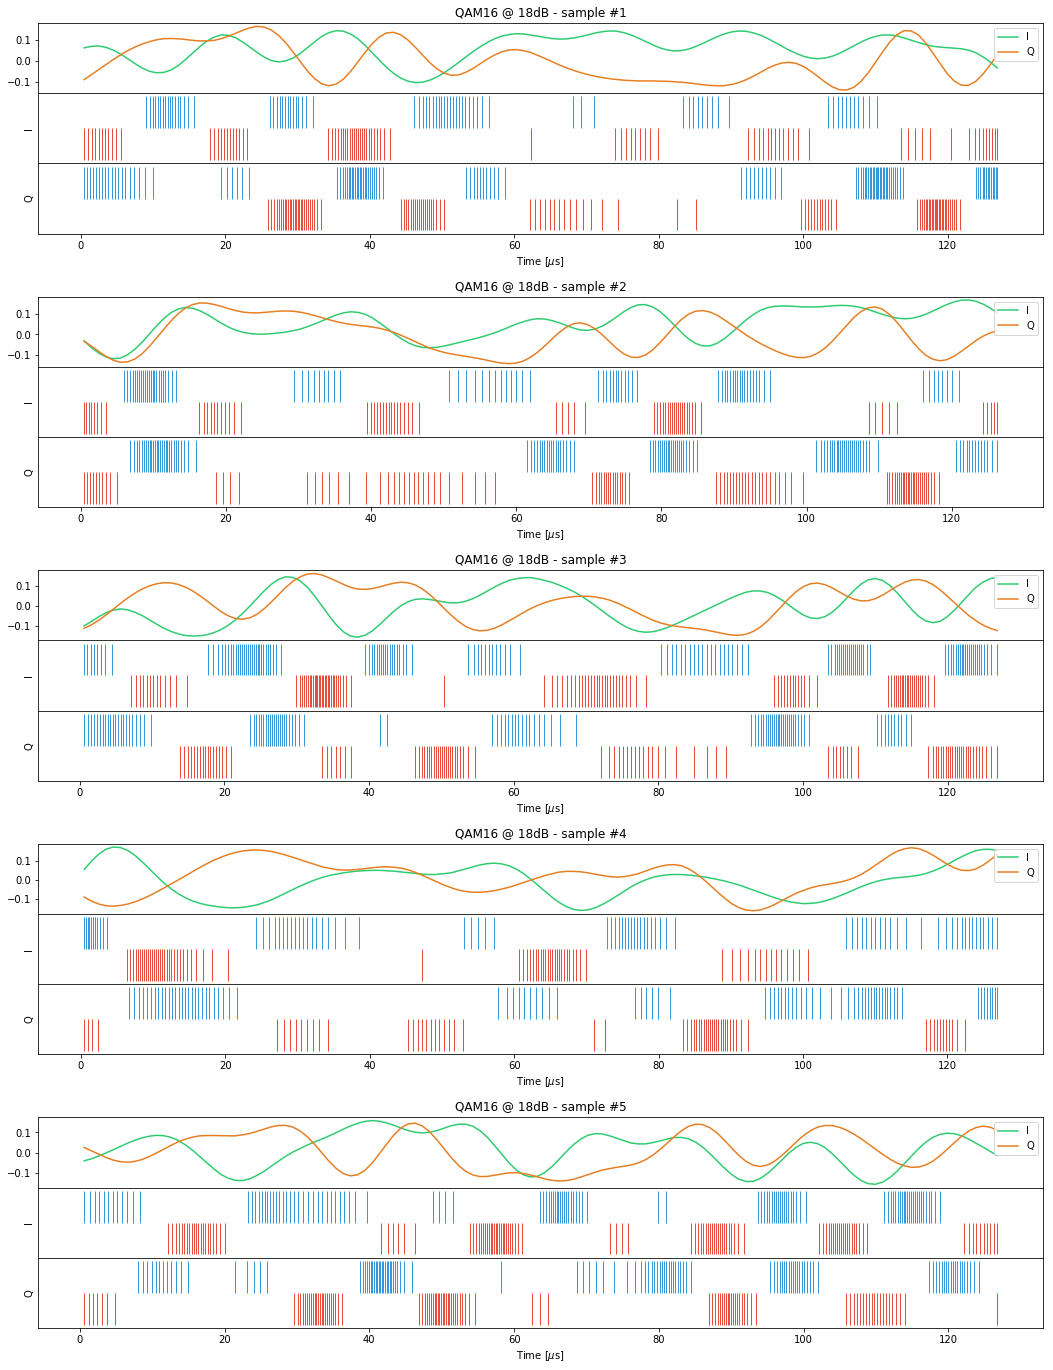

In [18]:
examples = dataset[('QAM16', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, 'QAM16', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

### PAM4
Pulse-amplitude modulation (PAM), is a form of signal modulation where the message information is encoded in the amplitudes of a train of carrier pulses, which are varied according to the sample value of the message signal. PAM4 has 4 discrete values.

Minimal interspiking time interval: 0.005 [us]
Mean spike counts:
	 - I.up: 103.2
	 - I.dn: 101.4
	 - Q.up: 88.0
	 - Q.dn: 85.8


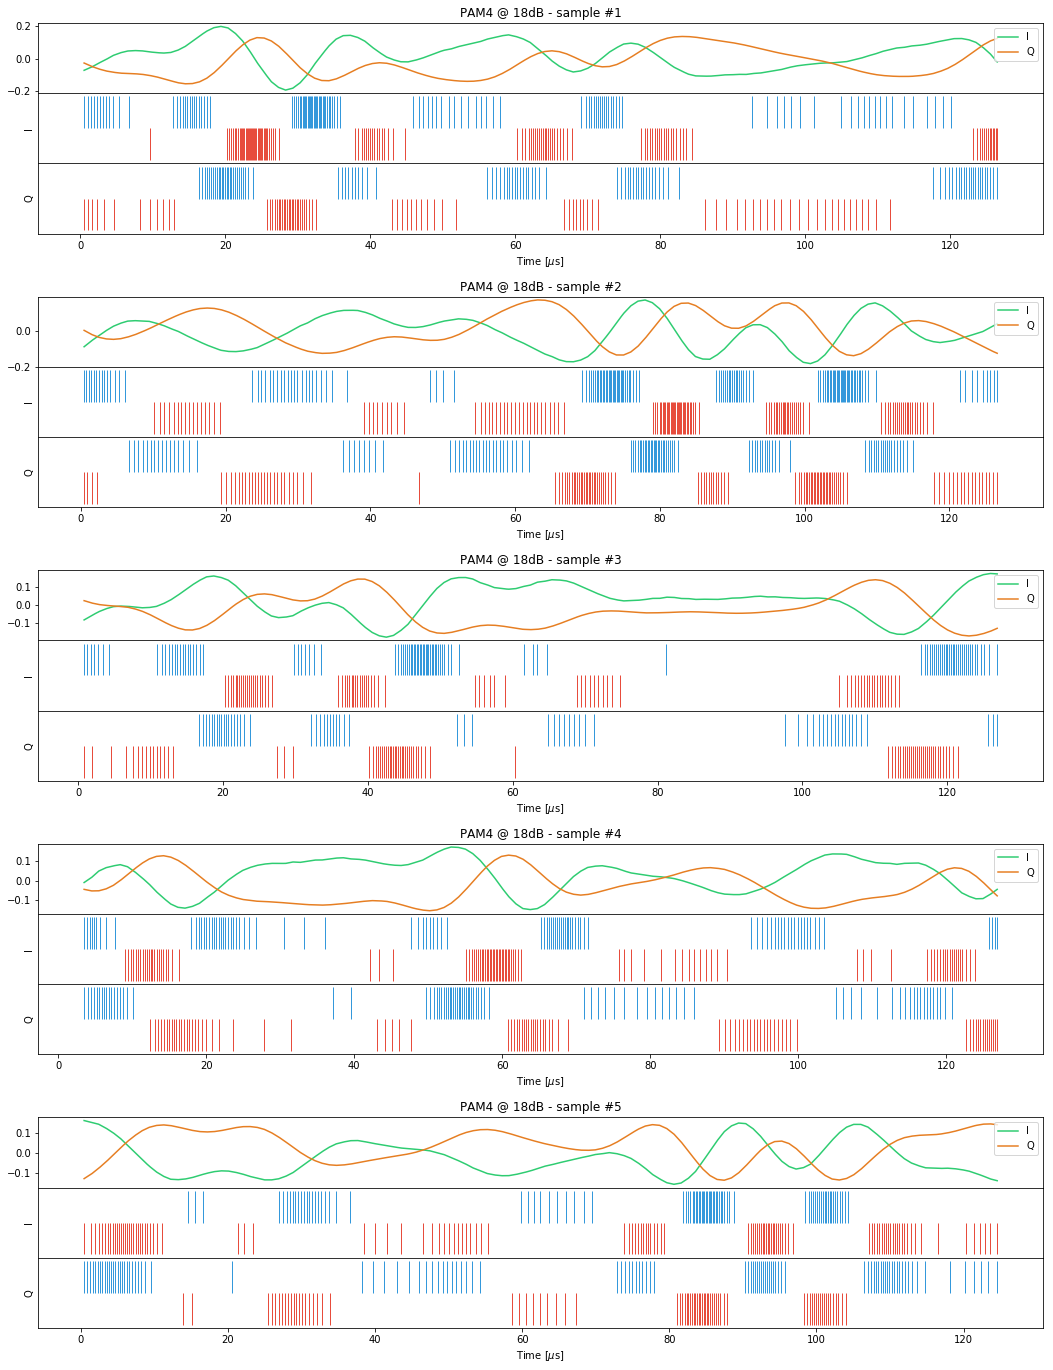

In [19]:
examples = dataset[('PAM4', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
counts = plot_examples(examples, 'PAM4', 18)
print("Minimal interspiking time interval: {:.1g} [us]".format(adm_I.time_step))
print("Mean spike counts:")
for (i, l) in enumerate(labels):
    print("\t - {}: {}".format(l, counts[:, i].mean()))

## Reconstruction

In order to assess the performance of the Delta Modulator, we compare the input signal to the signal reconstructed from the spike train.

In [20]:
def plot_reconstructions(examples, mod, snr):
    fig = plt.figure(figsize=(18, 24))
    grid = grs.GridSpec(len(examples), 1, wspace=0.3, hspace=0.3)
    for (i, e) in enumerate(examples):
        adm_I.interpolate(time, e[0, :])
        adm_Q.interpolate(time, e[1, :])
        adm_I.encode()
        adm_Q.encode()
        adm_I.decode()
        adm_Q.decode()
        inner_grid = grs.GridSpecFromSubplotSpec(2, 1,
                subplot_spec=grid[i], wspace=0.0, hspace=0.0)
        ax1 = plt.Subplot(fig, inner_grid[0])
        ax1.set_title('{} @ {}dB - sample #{}'.format(mod, snr, i+1))
        ax1.plot(adm_I.time_resampled, adm_I.vin, color='#2ecc71', label='original')
        ax1.plot(adm_I.time_resampled, adm_I.rec, color='#e67e22', label='reconstructed')
        ax1.set_ylabel('I')
        ax1.legend(loc='upper right')
        ax2 = plt.Subplot(fig, inner_grid[1])
        ax2.plot(adm_Q.time_resampled, adm_Q.vin, color='#2ecc71', label='original')
        ax2.plot(adm_Q.time_resampled, adm_Q.rec, color='#e67e22', label='reconstructed')
        ax2.set_ylabel('Q')
        ax2.legend(loc='upper right')
        fig.add_subplot(ax1)
        fig.add_subplot(ax2)

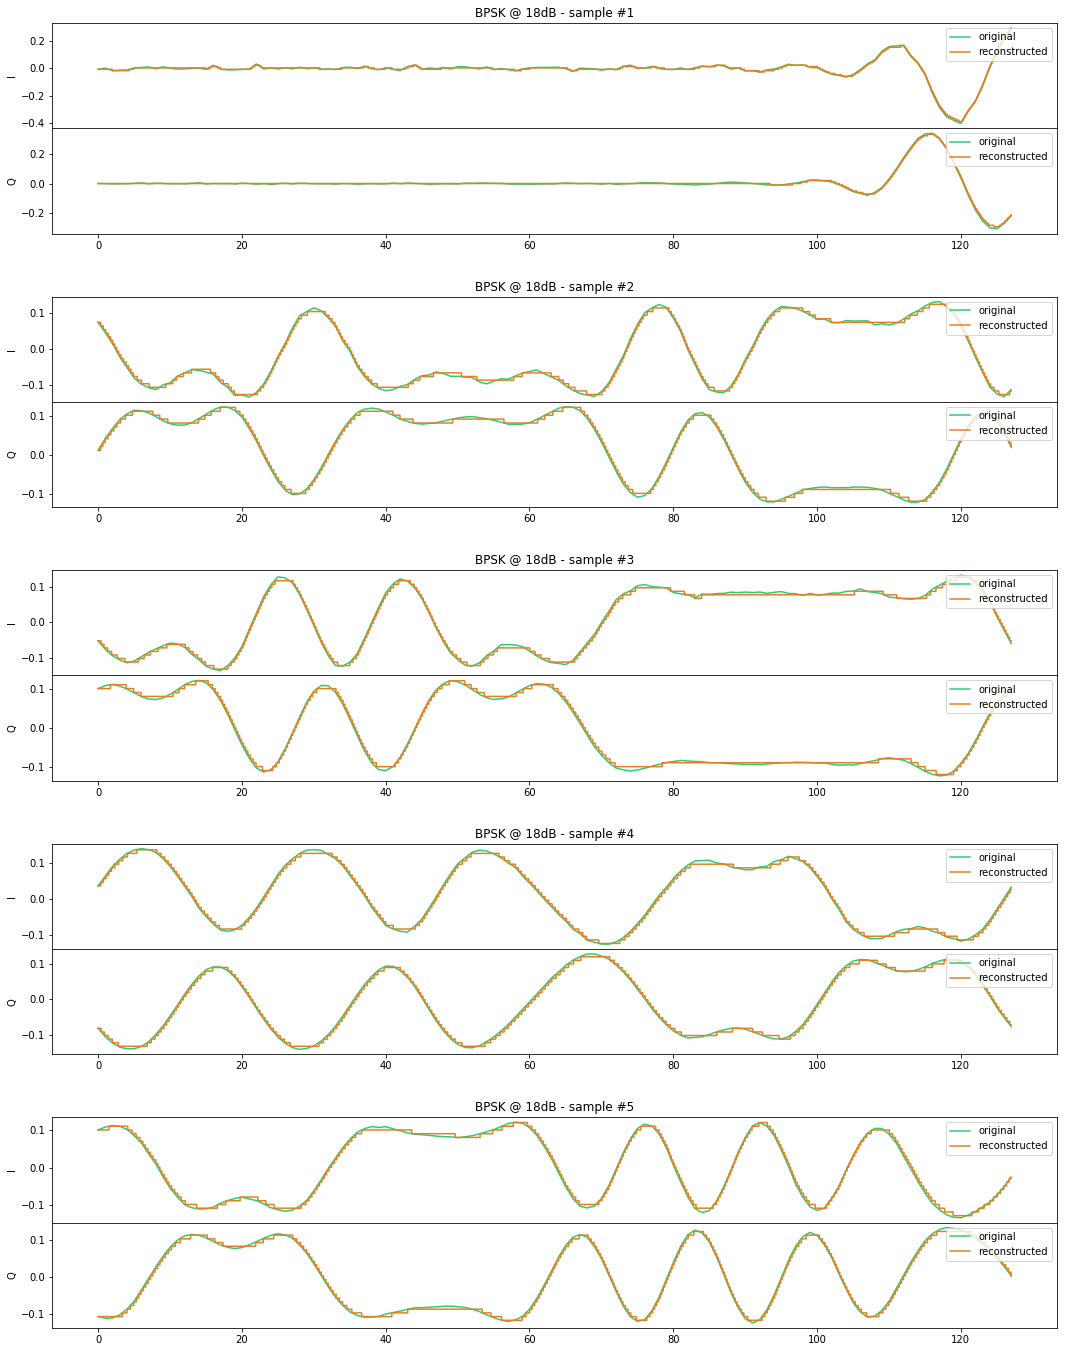

In [21]:
examples = dataset[('BPSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, 'BPSK', 18)

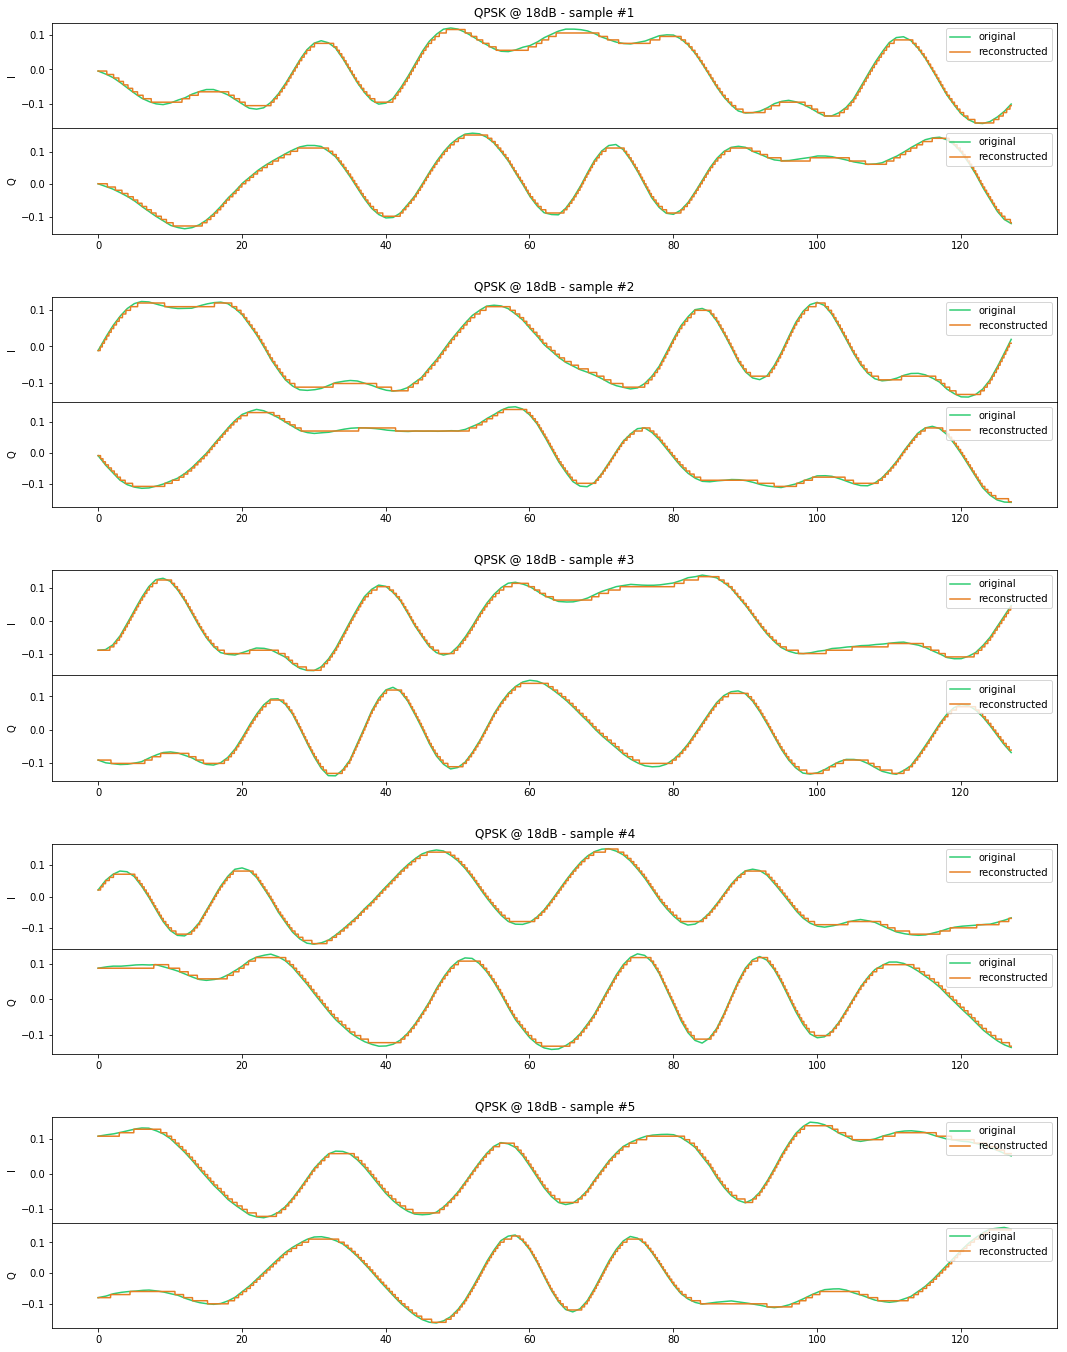

In [22]:
examples = dataset[('QPSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, 'QPSK', 18)

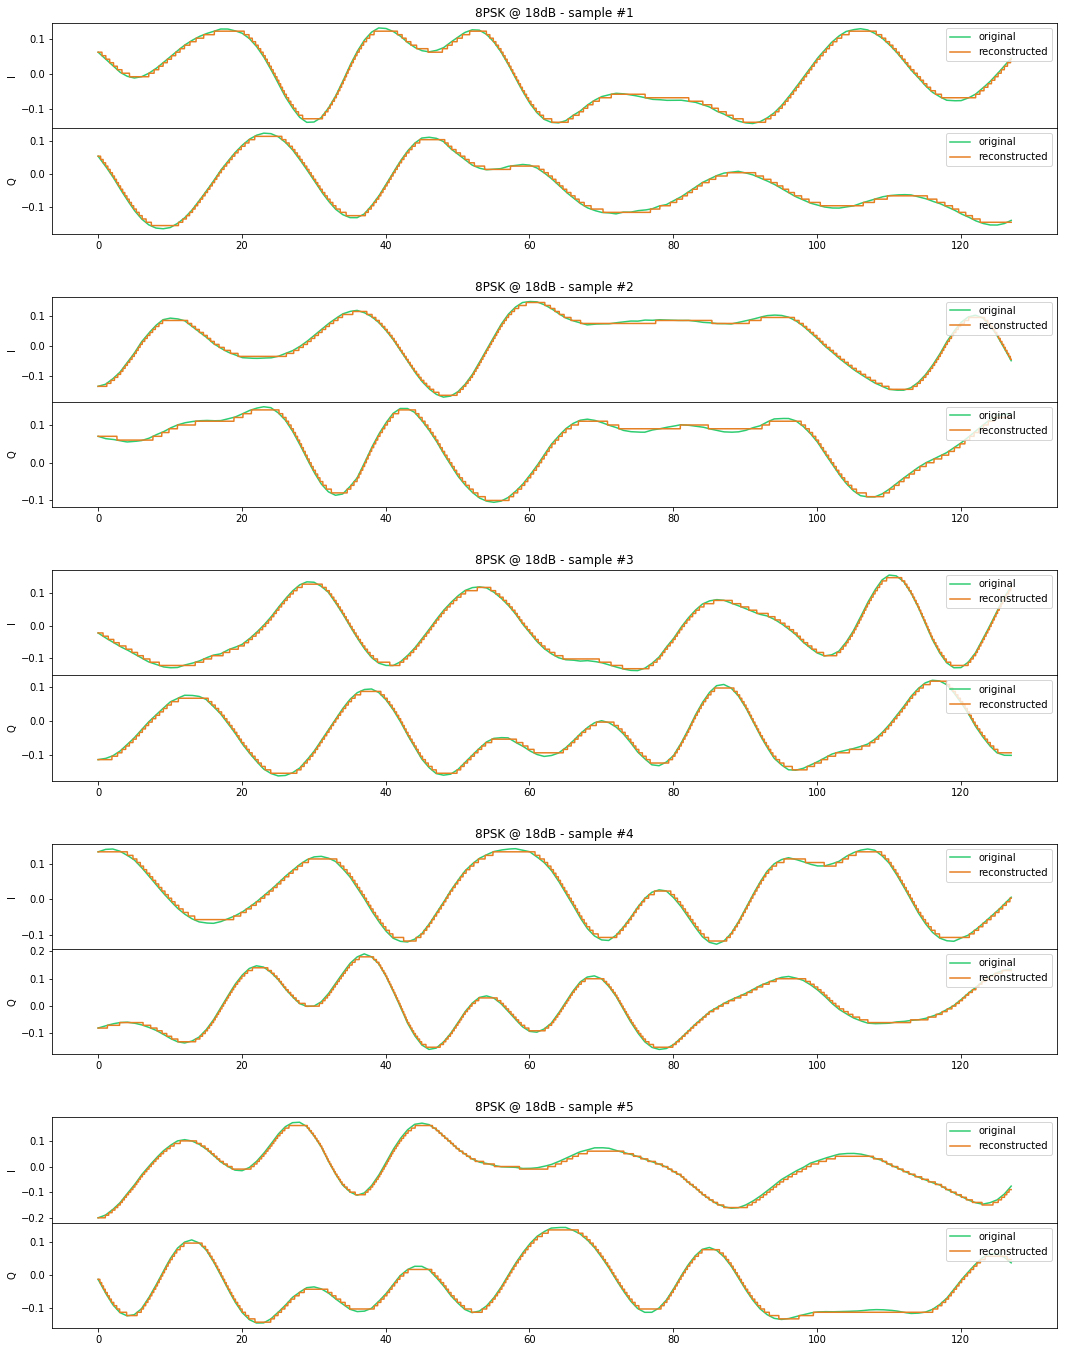

In [26]:
examples = dataset[('8PSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, '8PSK', 18)

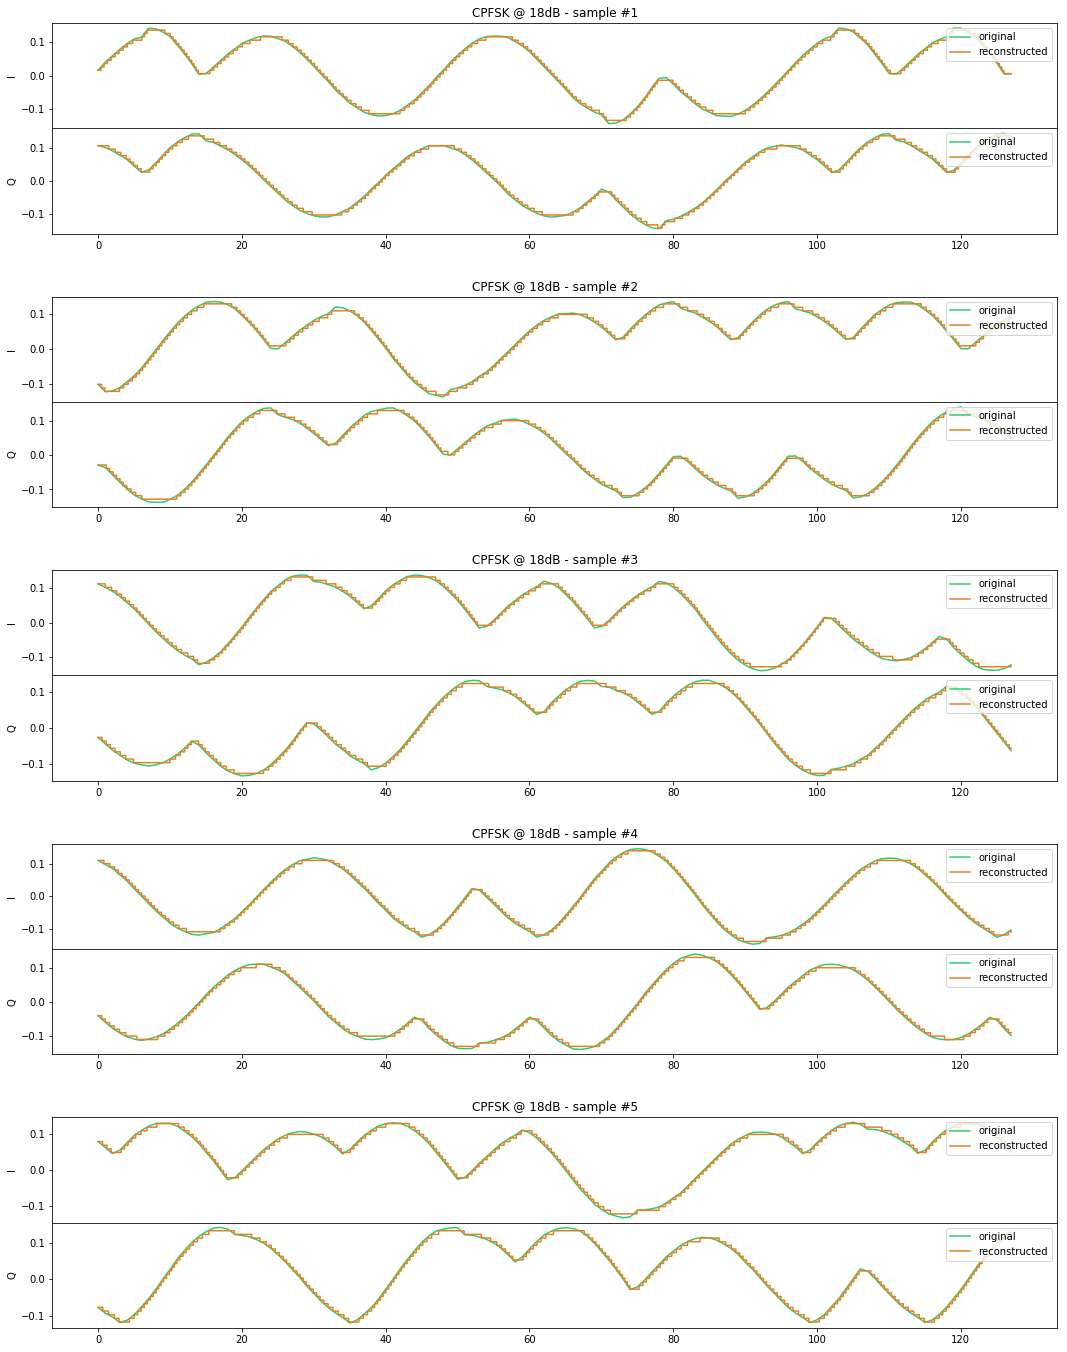

In [27]:
examples = dataset[('CPFSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, 'CPFSK', 18)

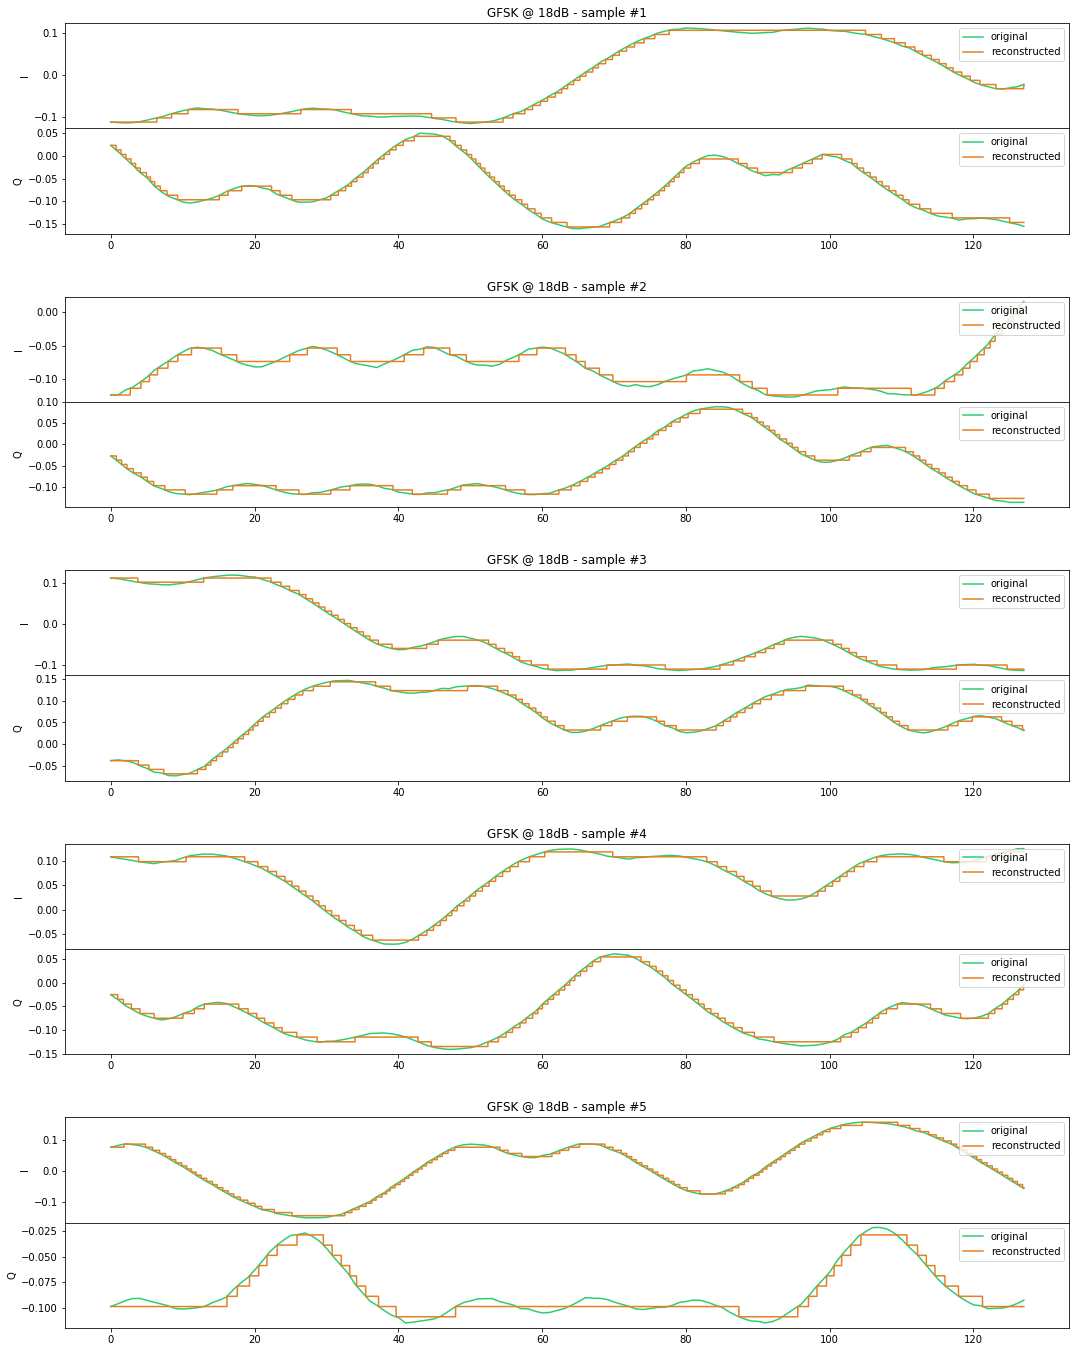

In [28]:
examples = dataset[('GFSK', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, 'GFSK', 18)

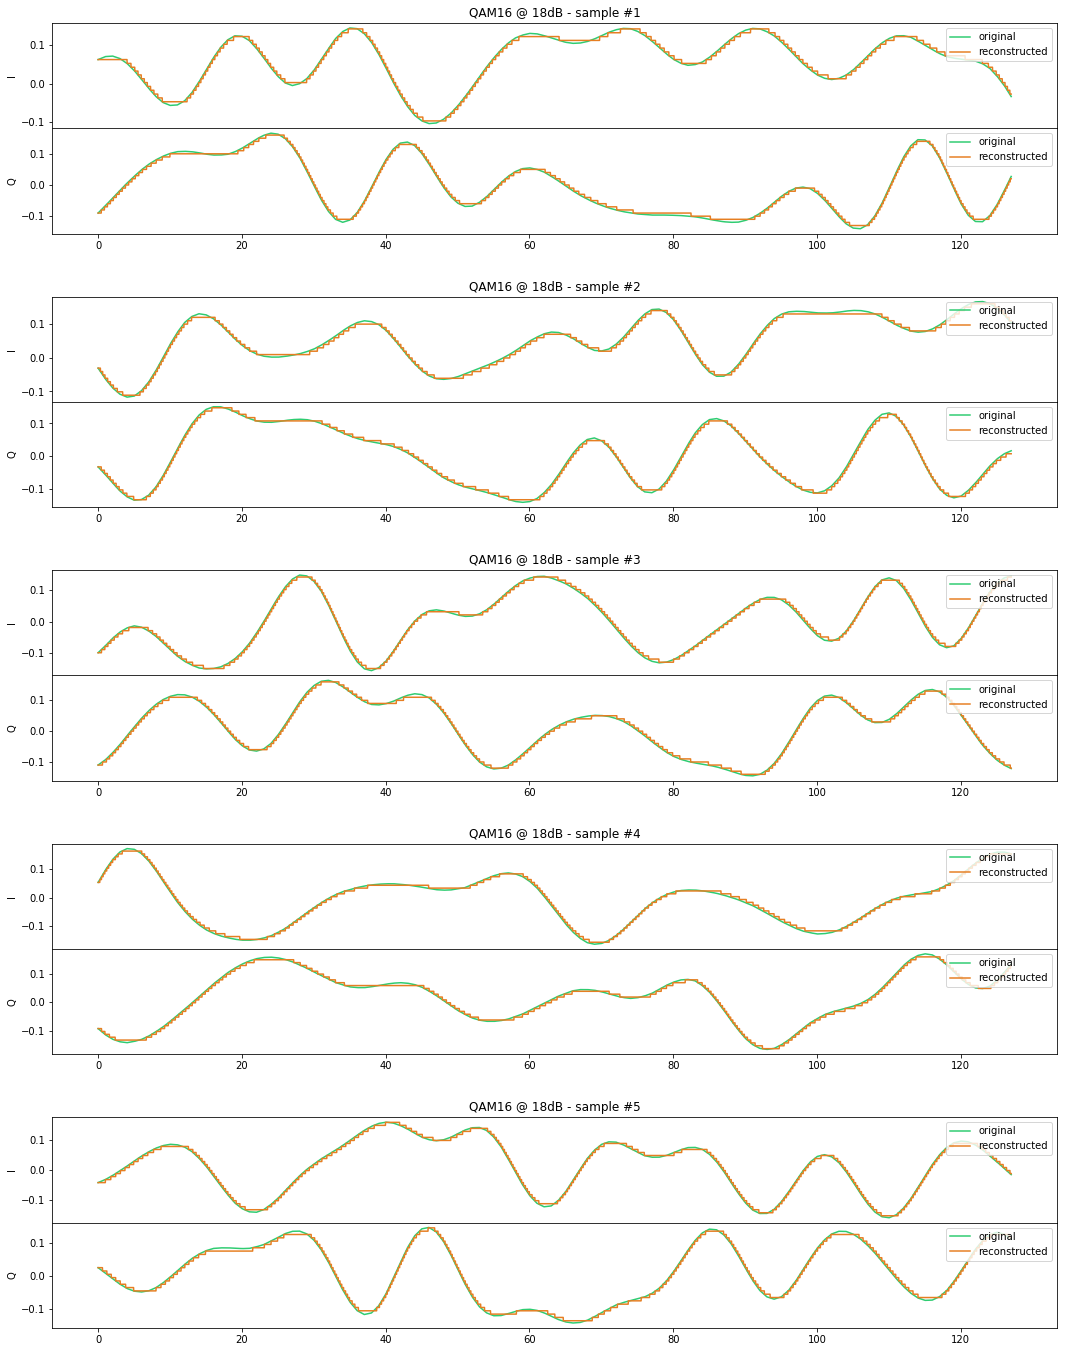

In [29]:
examples = dataset[('QAM16', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, 'QAM16', 18)

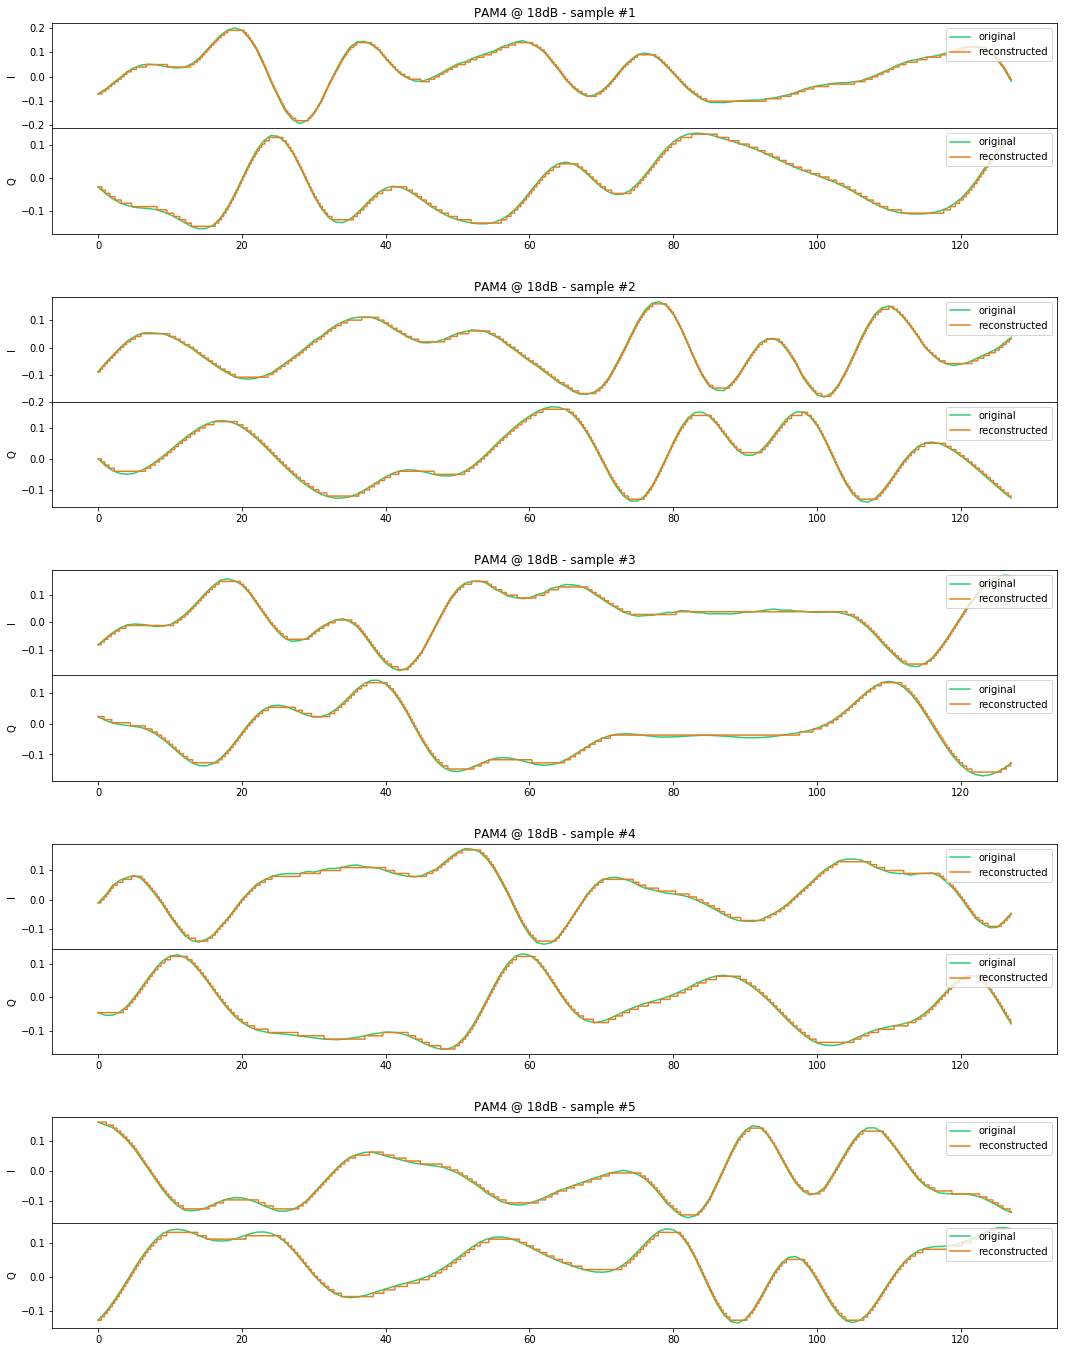

In [30]:
examples = dataset[('PAM4', 18)][:5]
examples[:,0,:] = Normalizer(copy=False).fit_transform(examples[:,0,:])
examples[:,1,:] = Normalizer(copy=False).fit_transform(examples[:,1,:])
plot_reconstructions(examples, 'PAM4', 18)